# Recurrent Neural Networks (RNNs) 

In [1]:
# reset variables
%reset -f

In [2]:
# import external modules
import sys, os
ROOT_PATH = os.path.abspath(".").split("src")[0]
module_path = os.path.abspath(os.path.join(ROOT_PATH+"/src/utils/"))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc 
from datetime import datetime
from tabulate import tabulate
from decimal import Decimal

import keras
print("keras.__version__ =", keras.__version__ )
from keras import layers, regularizers, Input, Model
from keras.optimizers import RMSprop, Adam, Nadam
from keras.initializers import RandomUniform
from keras.models import Sequential
from keras import backend as K

import tensorflow as tf
tf.set_random_seed(100)
print("tf.__version__ =", tf.__version__)
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from functions import MAE, RMSE, split_dataset

Using TensorFlow backend.


keras.__version__ = 2.2.4
tf.__version__ = 1.12.0


In [17]:
# configure matplotlib params and plotting
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')

SEED=100
np.random.seed(SEED)

### Load data

In [4]:
path = ROOT_PATH + "data/dataframes/"
df_train = pd.read_pickle(path + "df_selected_train.pkl")
df_valid = pd.read_pickle(path + "df_selected_valid.pkl")
df_test = pd.read_pickle(path + "df_selected_test.pkl")

USE_DUMMY_DATA = False
if USE_DUMMY_DATA: 
    num_obs = 5000  # 5000, 10000 or 25000
    path = ROOT_PATH + "data/dummy/"
    df_train = pd.read_pickle(path + "dummy_train_{0}.pkl".format(num_obs))
    df_valid = pd.read_pickle(path + "dummy_valid_{0}.pkl".format(num_obs))
    df_test = pd.read_pickle(path + "dummy_test_{0}.pkl".format(num_obs))

# splitting into training, testing and validation sets
x_train, y_train = split_dataset(df_train.values, delay=1)
x_valid, y_valid = split_dataset(df_valid.values, delay=1)
x_test, y_test = split_dataset(df_test.values, delay=1)

# reading metadata
path = ROOT_PATH + "data/metadata/"

# stats for scaling
stats = pd.read_csv(path+"stats_selected.csv", index_col=0)

# tags
headers = df_train.columns.values
target_tags = headers[:3]
feature_tags = headers[3:]

# timestamps
ts = np.load(path + "timestamps/dtimestamps.npy")
ts_train = np.load(path + "timestamps/ts_train.npy")
ts_valid = np.load(path + "timestamps/ts_valid.npy")
ts_test = np.load(path + "timestamps/ts_test.npy")

print(df_train.shape, df_valid.shape, df_test.shape)
print(x_train.shape, y_train.shape)

(53211, 9) (17737, 9) (17737, 9)
(53210, 6) (53210, 3)


# Functions

In [5]:
def batch_generator(x_data, y_data, lookback, batch_size=128):
    """
    Generator function for creating random batches of training-data.
    
    :param x_data: Numpy array of the features, not targets. 2D array, normalized/scaled, numpy.
    :param y_data: Numpy array of the targets, not features. 2D array, normalized/scaled, numpy. 
    :param lookback: How many timesteps back the input data should go.
    :param batch_size: The number of samples per batch.
    """
    num_x_signals = x_data.shape[1]
    num_y_signals = y_data.shape[1]

    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, lookback, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, lookback, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(x_data.shape[0] - lookback)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_data[idx:idx+lookback]
            y_batch[i] = y_data[idx:idx+lookback]
        
        yield (x_batch, y_batch)

In [6]:
def plot_history(history, savepath=None):
    """
    Plots the training and validation loss history of the model in the training phase. 
    """
    epochs = history.epoch

    train_mae = history.history['loss']
    val_mae = history.history['val_loss']

    plt.figure()
    plt.plot(epochs, train_mae, marker='o', markersize='3.0', label=r'Training loss', color="darkred")
    plt.plot(epochs, val_mae, marker='o', markersize='3.0', label=r'Validation loss', color="darkblue")  
    plt.xlabel(r'Epoch')
    plt.ylabel(r'MAE')
    plt.legend(frameon=True)
    if savepath is not None: 
        plt.savefig(savepath)
    plt.show()

In [7]:
def predict_with_model(model, x_data, y_data, n_predictions=50):
    x = x_data
    if len(x_data.shape) < 3:
        x = np.expand_dims(x_data, axis=0)
    
    n_obs, n_targets = y_data.shape
    preds_matr = np.zeros((n_predictions,n_obs,n_targets))  # (n_pred, predictions, num_targets)
    err_matr = np.zeros((n_predictions,n_targets))  # (n_pred, num_targets) - one error per target per run

    for it in range(n_predictions):
        preds = model.predict(x)[0]
        errs = MAE(y_data, preds, vector=True)
        
        preds_matr[it] = preds
        err_matr[it] = errs
    
    mean_predictions = np.array([np.mean(preds_matr[:,:,i], axis=0) for i in range(n_targets)]).T
    std_of_predictions = np.array([np.std(preds_matr[:,:,i], axis=0) for i in range(n_targets)]).T
    
    return mean_predictions, std_of_predictions, {'pred_matr': preds_matr, 'loss_matr': err_matr}
    

def get_model_maes(model, x_data, y_data, 
                   n_predictions=50, target_stds=stats.loc[target_tags, "Std"]):
    
    mean_preds, std_preds, pred_dict = predict_with_model(model, x_data, y_data, n_predictions)
    expected_mean = np.mean(mean_preds, axis=0)
    expected_std = np.mean(std_preds, axis=0) 
    maes = np.mean(pred_dict['loss_matr'], axis=0)
    maes_unstd = maes * target_stds
    
    # summarize in dataframe
    indexes = ["FT", "TT", "PT"]
    cols = ["MAE (std)", "MAE (unstd)", "Expect. Mean", "Expect. Stdev"]
    data = np.column_stack([maes, maes_unstd, expected_mean, expected_std])
    df = pd.DataFrame(data, index=indexes, columns=cols)
    df.loc["Avg"] = df.mean()
    
    # make a string representation of the dataframe
    str_table = tabulate(df, headers='keys', tablefmt='psql', floatfmt='.5f')
    
    return_dict = {
        'df': df,
        'str_table': str_table,
        'pred_matr': pred_dict['pred_matr'], # matrix of predictions for each run
        'loss_matr': pred_dict['loss_matr']  # matrix of losses for each run
    }
    
    return return_dict

def plot_multiple_predictions(model, x_data, y_data, time_vec, target_tags, 
                              start_idx=0, n_obs=200, n_predictions=50, plotCI=False):
    
    mean_preds, std_preds, pred_dict = predict_with_model(model, x_data, y_data, n_predictions)
    preds_matr = pred_dict['pred_matr']
    
    n_targets = y_data.shape[-1]
    n_iterations = preds_matr.shape[0]
    
    start_idx = start_idx if start_idx < len(y_data) else max(0,len(y_data)-n_obs) 
    end_idx = min(len(y_data),start_idx+n_obs)
    interval = range(start_idx,end_idx)
    
    time = time_vec[interval]
    
    for signal in range(n_targets):
        plt.figure()
        if not plotCI: # then plot individual predictions 
            for run in range(n_iterations):
                preds = preds_matr[run, interval, signal]
                plt.plot_date(time, preds, alpha=0.3, color="gray", markersize=0, linestyle="-")
        else: 
            # calculate upper and lower bounds
            z = 1.96 #95% CI
            CI_low = np.subtract(mean_preds,std_preds*z)
            CI_high = np.add(mean_preds,std_preds*z)
            
            # plot it
            plt.fill_between(time,
                             CI_low[interval,signal], 
                             CI_high[interval,signal], 
                             color="gray", alpha=0.5, label="95% CI")
    
        y_pred_mean = mean_preds[interval, signal]
        y_signal_true = y_data[interval, signal]
        
        plt.plot_date(time, y_pred_mean, color="darkblue", 
                      linewidth=1.5, linestyle="-", markersize=0, label="Mean prediction")
        plt.plot_date(time, y_signal_true, color="darkred", 
                      linewidth=1.5, linestyle="-", markersize=0, label="True")
        plt.ylabel(target_tags[signal])
        plt.legend(frameon=True)
        plt.show()
    

In [8]:
def evaluate_model(model_func,train_tuple, valid_tuple, test_tuple,
                   name, target_stds, target_tags,
                   generator_func=batch_generator,n_predictions=50,
                   lookback=300,batch_size=256,epochs=30,makeplots=True):
    
    """
    Evaluates a model architecture
    """
    
    root_path = os.path.abspath(".").split("src")[0]
    model_folder = root_path + "models/{0}/{1}/".format(name,epochs)
    if not os.path.exists(model_folder):
        print("Creating directory", model_folder)
        os.makedirs(model_folder)
    
    weights_checkpoint = model_folder + "weights.h5".format(name)
    
    callbacks = [
        ModelCheckpoint(
            filepath=weights_checkpoint, monitor='val_loss',verbose=1,
            save_weights_only=True,save_best_only=True
        ),
        
        keras.callbacks.ReduceLROnPlateau(
            monitor = 'loss', factor = 0.5, patience = 3, verbose = 1, min_lr=5e-4,
        )
    ]
    
    train_gen = generator_func(train_tuple[0], train_tuple[1], lookback, batch_size)
    train_steps = len(train_tuple[0]) // batch_size
                      
    validation_data = (np.expand_dims(valid_tuple[0], axis=0),
                       np.expand_dims(valid_tuple[1], axis=0))
    
    model = model_func(train_tuple[0].shape, train_tuple[1].shape)
    model.compile(loss='mae', optimizer=Adam(lr=1e-3))
    history = model.fit_generator(generator=train_gen,
                                  epochs=epochs,
                                  steps_per_epoch=train_steps,
                                  validation_data=validation_data,
                                  callbacks=callbacks)
    
    # plot the training history
    plot_history(history, model_folder + "history.png".format(name))
    
    # save the model and load the weights of the best epoch 
    model.save(model_folder + "model.h5")
    model.load_weights(weights_checkpoint) 
    
    # evaluate the model on validation/testing data
    # ** Validation data **
    val_dict = get_model_maes(model, valid_tuple[0], valid_tuple[1], n_predictions, target_stds)
    print(" **** VALIDATION DATA ****")
    print(val_dict['str_table'])
                      
    # ** Testing data **
    test_dict = get_model_maes(model, test_tuple[0], test_tuple[1], n_predictions, target_stds)
    print(" **** TEST DATA ****")
    print(test_dict['str_table'])
    
    # Save results files
    val_dict['df'].to_pickle(model_folder + "dfval.pkl")
    test_dict['df'].to_pickle(model_folder + "dftest.pkl")

    # If makeplots = True, then plot the predictions with the mean 
    if makeplots: 
        plot_multiple_predictions(model, x_valid, y_valid, ts_valid, target_tags)
    
    return_dict = {
        'model': model,
        'history': history,
        'validation': val_dict,
        'test': test_dict,
    }
    
    return return_dict

In [9]:
def make_summary_for_dict(model_dict, 
                          valid_tuple=(x_valid, y_valid), 
                          test_tuple=(x_test, y_test), 
                          time_tuple=(ts_valid, ts_test), 
                          target_tags=target_tags, 
                          start_idx=500, 
                          n_obs=6*60):
    
    # print summary of architecture
    model_dict['model'].summary()

    print("\n **** VALIDATION DATA **** \n")
    print(model_dict['validation']['str_table'])

    print("\n **** TEST DATA **** \n")
    print(model_dict['test']['str_table'])
    
    print("\n **** Training vs validation history ****")
    plot_history(model_dict['history'])
    
    print("\n **** PLOTS ****")
    print(" **** VALIDATION DATA **** \n")
    plot_multiple_predictions(model_dict['model'], valid_tuple[0], valid_tuple[1], 
                              time_tuple[0], target_tags, start_idx, n_obs, plotCI=False)
    
    print("\n **** TEST DATA **** \n")
    plot_multiple_predictions(model_dict['model'], test_tuple[0], test_tuple[1], 
                              time_tuple[1], target_tags, start_idx, n_obs, plotCI=False)
    
    print("\n **** PLOTS /W CI INTERVALS ---")
    print(" **** VALIDATION DATA **** \n")
    plot_multiple_predictions(model_dict['model'], valid_tuple[0], valid_tuple[1], 
                              time_tuple[0], target_tags, start_idx, n_obs, plotCI=True)
    
    print("\n **** TEST DATA **** \n")
    plot_multiple_predictions(model_dict['model'], test_tuple[0], test_tuple[1], 
                              time_tuple[1], target_tags, start_idx, n_obs, plotCI=True)

# LSTM

In [13]:
def lstm_architecture(x_shape, y_shape): 
    input_layer = Input(shape=(None,x_shape[-1]))
    layer_1 = layers.LSTM(128,
                         dropout = 0.3,
                         recurrent_dropout = 0.3,
                         return_sequences = True)(input_layer, training=True)

    output_layer = layers.Dense(y_shape[-1])(layer_1)
    
    model = Model(input_layer, output_layer) 
    return model

Epoch 1/50
207/207 [==============================] - 98s 476ms/step - loss: 0.5073 - val_loss: 0.4993

Epoch 00001: val_loss improved from inf to 0.49932, saving model to /home/shomeb/h/halvorre/master-thesis/models/lstm_128/50/weights.h5
Epoch 2/50
207/207 [==============================] - 99s 478ms/step - loss: 0.4238 - val_loss: 0.5019

Epoch 00003: val_loss did not improve from 0.49932
Epoch 4/50
207/207 [==============================] - 99s 478ms/step - loss: 0.4132 - val_loss: 0.4737

Epoch 00004: val_loss improved from 0.49932 to 0.47369, saving model to /home/shomeb/h/halvorre/master-thesis/models/lstm_128/50/weights.h5
Epoch 5/50
207/207 [==============================] - 99s 478ms/step - loss: 0.4060 - val_loss: 0.4638

Epoch 00005: val_loss improved from 0.47369 to 0.46380, saving model to /home/shomeb/h/halvorre/master-thesis/models/lstm_128/50/weights.h5
Epoch 6/50
207/207 [==============================] - 99s 478ms/step - loss: 0.3996 - val_loss: 0.4770

Epoch 00006: 

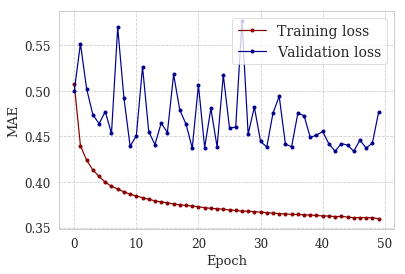

 **** VALIDATION DATA ****
+-----+-------------+---------------+----------------+-----------------+
|     |   MAE (std) |   MAE (unstd) |   Expect. Mean |   Expect. Stdev |
|-----+-------------+---------------+----------------+-----------------|
| FT  |     0.60477 |    2042.11139 |       -0.31172 |         0.19596 |
| TT  |     0.34179 |       0.33377 |        1.27380 |         0.24846 |
| PT  |     0.42965 |       0.10633 |        0.00826 |         0.17221 |
| Avg |     0.45874 |     680.85050 |        0.32345 |         0.20554 |
+-----+-------------+---------------+----------------+-----------------+
 **** TEST DATA ****
+-----+-------------+---------------+----------------+-----------------+
|     |   MAE (std) |   MAE (unstd) |   Expect. Mean |   Expect. Stdev |
|-----+-------------+---------------+----------------+-----------------|
| FT  |     0.54519 |    1840.91831 |       -0.46707 |         0.20984 |
| TT  |     0.31609 |       0.30867 |        1.76193 |         0.21043 |
| P

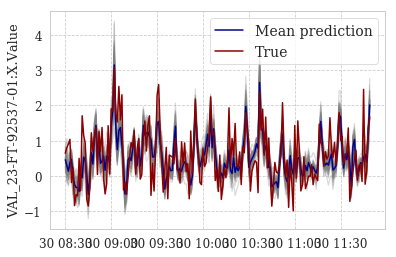

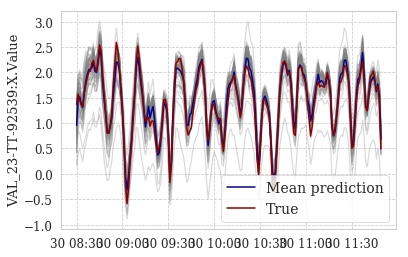

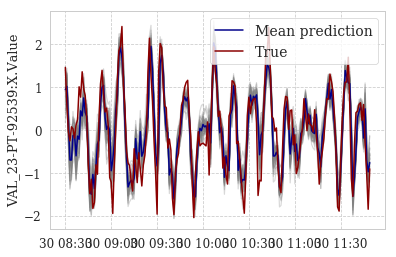

In [14]:
K.clear_session()

name = "lstm_128"
n_predictions = 50 
lookback = 6 * 60
batch_size = 256
epochs = 50

lstm_128_dict = evaluate_model(model_func=lstm_architecture,
                               train_tuple=(x_train, y_train),
                               valid_tuple=(x_valid, y_valid),
                               test_tuple=(x_test, y_test),
                               name=name,
                               target_stds=stats.loc[target_tags,"Std"].values,
                               target_tags=target_tags,
                               generator_func=batch_generator,
                               n_predictions=n_predictions,
                               lookback=lookback,
                               batch_size=batch_size,
                               epochs=epochs,
                               makeplots=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 6)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         69120     
_________________________________________________________________
dense_1 (Dense)              (None, None, 3)           387       
Total params: 69,507
Trainable params: 69,507
Non-trainable params: 0
_________________________________________________________________

 **** VALIDATION DATA **** 

+-----+-------------+---------------+----------------+-----------------+
|     |   MAE (std) |   MAE (unstd) |   Expect. Mean |   Expect. Stdev |
|-----+-------------+---------------+----------------+-----------------|
| FT  |     0.60477 |    2042.11139 |       -0.31172 |         0.19596 |
| TT  |     0.34179 |       0.33377 |        1.27380 |         0.24846 |
| PT  |

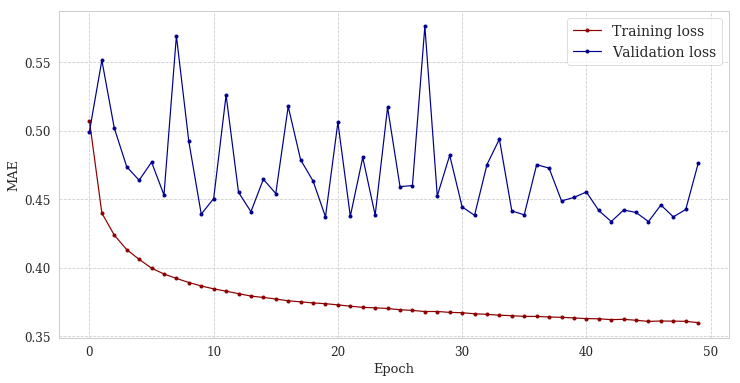


 **** PLOTS ****
 **** VALIDATION DATA **** 



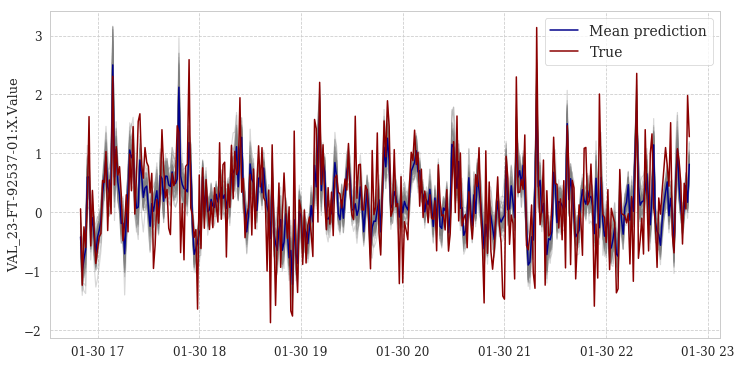

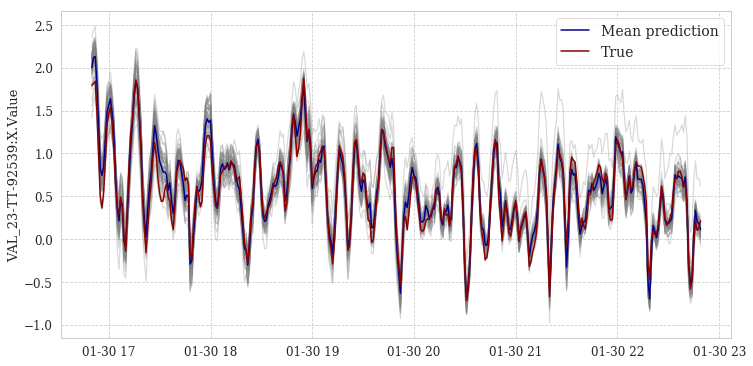

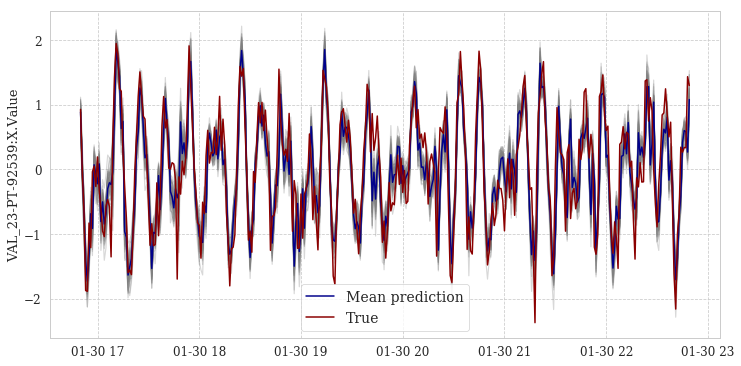


 **** TEST DATA **** 



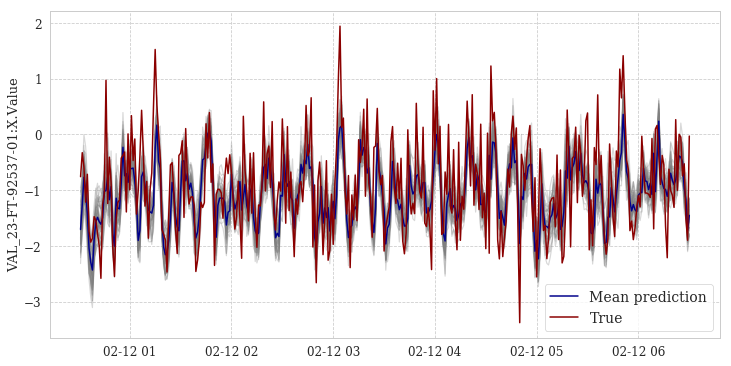

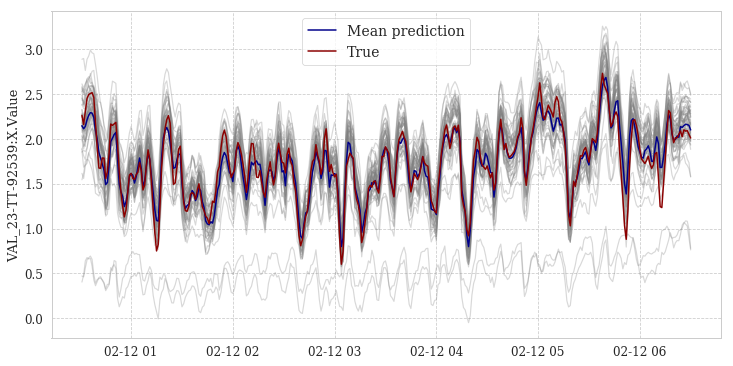

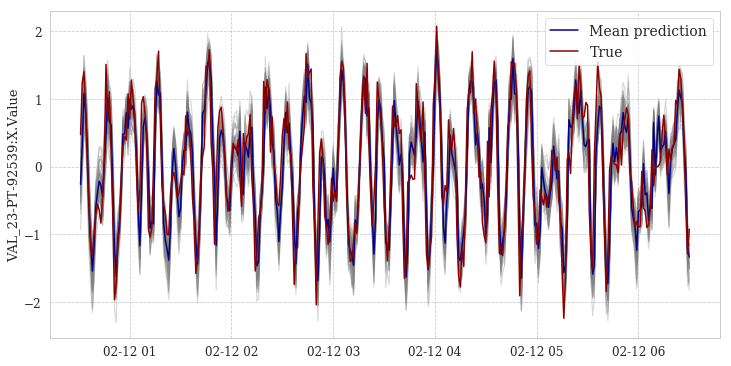


 **** PLOTS /W CI INTERVALS ---
 **** VALIDATION DATA **** 



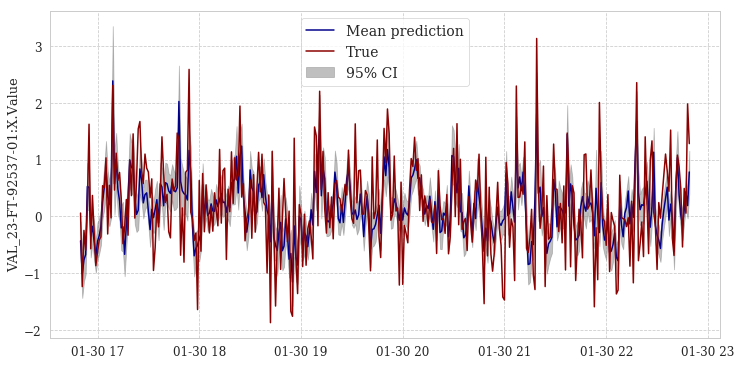

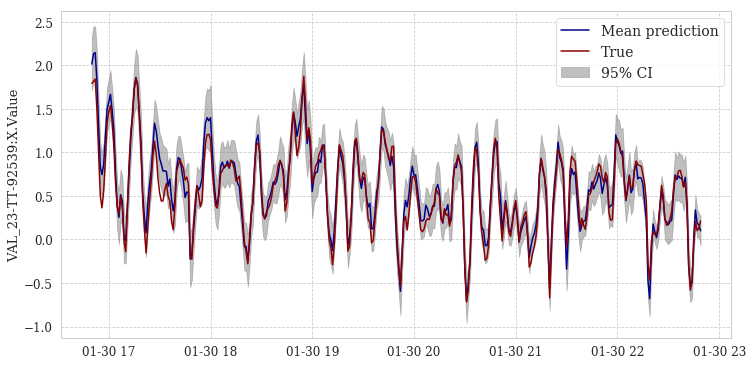

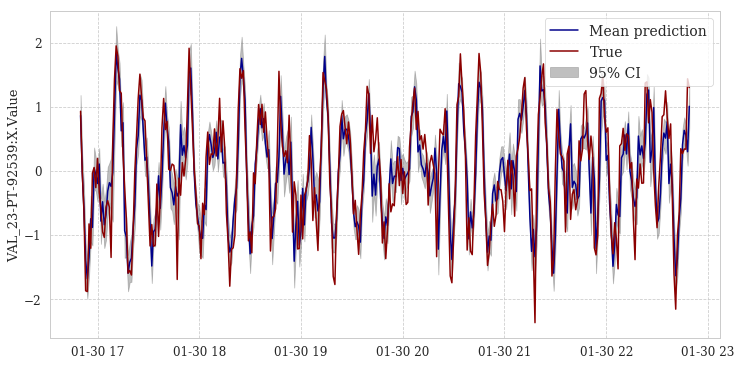


 **** TEST DATA **** 



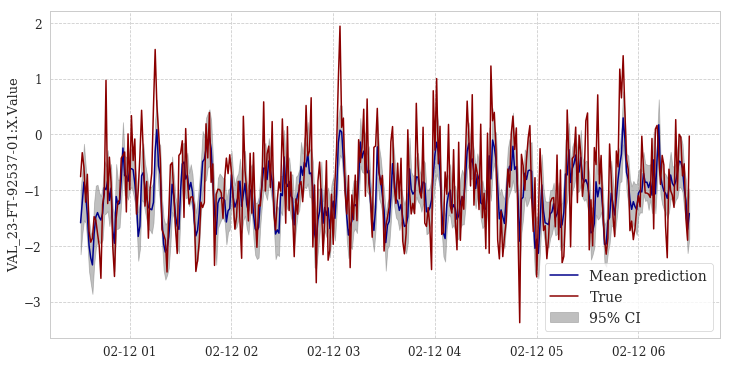

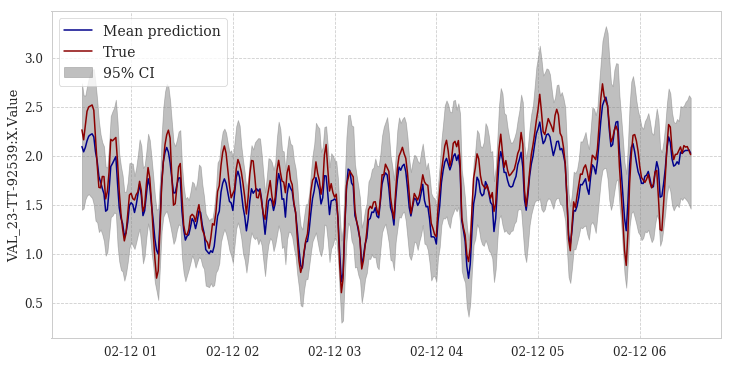

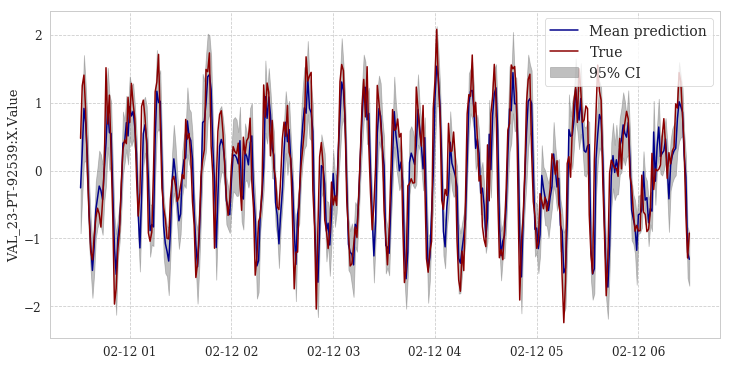

In [19]:
make_summary_for_dict(lstm_128_dict)

# GRU Network

In [26]:
def gru_architecture(x_shape, y_shape): 
    input_layer = Input(shape=(None,x_shape[-1]))
    layer_1 = layers.GRU(128,
                         dropout = 0.3,
                         recurrent_dropout = 0.3,
                         return_sequences = True)(input_layer, training=True)

    output_layer = layers.Dense(y_shape[-1])(layer_1)
    
    model = Model(input_layer, output_layer) 
    return model

In [27]:
K.clear_session()

name = "gru_128"
n_predictions = 50 
lookback = 6 * 60
batch_size = 256
epochs = 50

gru_128_dict = evaluate_model(model_func=gru_architecture,
                              train_tuple=(x_train, y_train),
                              valid_tuple=(x_valid, y_valid),
                              test_tuple=(x_test, y_test),
                              name=name,
                              target_stds=stats.loc[target_tags,"Std"].values,
                              target_tags=target_tags,
                              generator_func=batch_generator,
                              n_predictions=n_predictions,
                              lookback=lookback,
                              batch_size=batch_size,
                              epochs=epochs)

Creating directory /home/shomeb/h/halvorre/master-thesis/models/gru_128/50/
Epoch 1/50
207/207 [==============================] - 90s 436ms/step - loss: 0.5308 - val_loss: 0.6723

Epoch 00001: val_loss improved from inf to 0.67235, saving model to /home/shomeb/h/halvorre/master-thesis/models/gru_128/50/weights.h5
Epoch 2/50
207/207 [==============================] - 91s 439ms/step - loss: 0.4708 - val_loss: 0.5154

Epoch 00002: val_loss improved from 0.67235 to 0.51540, saving model to /home/shomeb/h/halvorre/master-thesis/models/gru_128/50/weights.h5
Epoch 3/50
207/207 [==============================] - 91s 440ms/step - loss: 0.4421 - val_loss: 0.6081

Epoch 00003: val_loss did not improve from 0.51540
Epoch 4/50
207/207 [==============================] - 91s 441ms/step - loss: 0.4289 - val_loss: 0.4902

Epoch 00004: val_loss improved from 0.51540 to 0.49022, saving model to /home/shomeb/h/halvorre/master-thesis/models/gru_128/50/weights.h5
Epoch 5/50
207/207 [========================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 6)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, None, 128)         51840     
_________________________________________________________________
dense_1 (Dense)              (None, None, 3)           387       
Total params: 52,227
Trainable params: 52,227
Non-trainable params: 0
_________________________________________________________________

 **** VALIDATION DATA **** 

+-----+-------------+---------------+----------------+-----------------+
|     |   MAE (std) |   MAE (unstd) |   Expect. Mean |   Expect. Stdev |
|-----+-------------+---------------+----------------+-----------------|
| FT  |     0.61815 |    2087.28504 |       -0.26038 |         0.22230 |
| TT  |     0.32203 |       0.31447 |        1.23703 |         0.20927 |
| PT  |

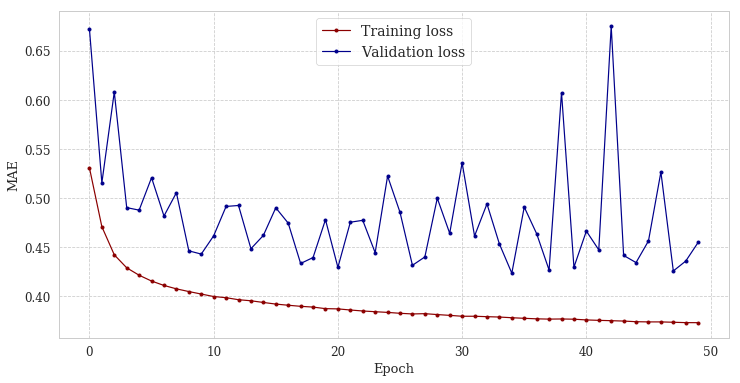


 **** PLOTS ****
 **** VALIDATION DATA **** 



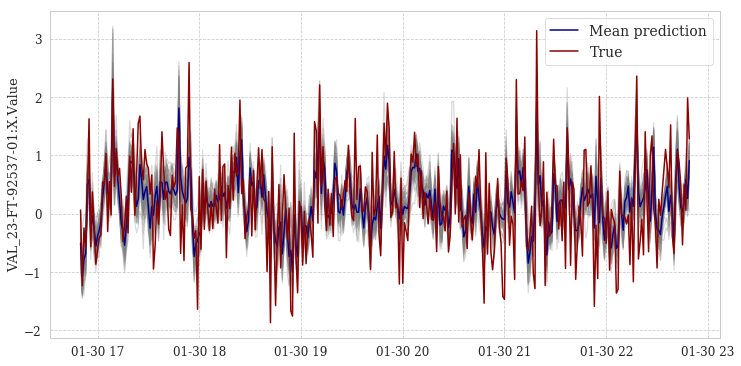

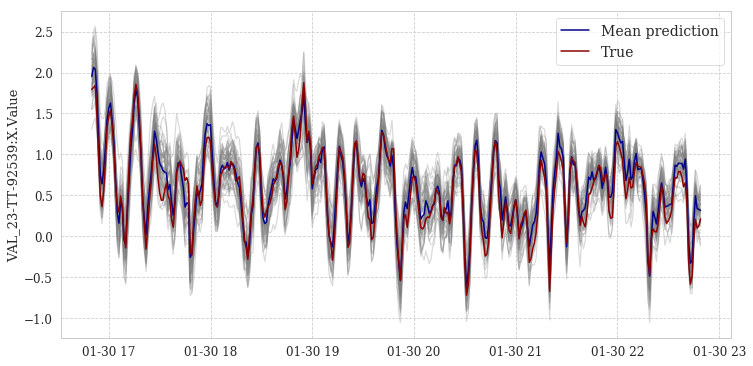

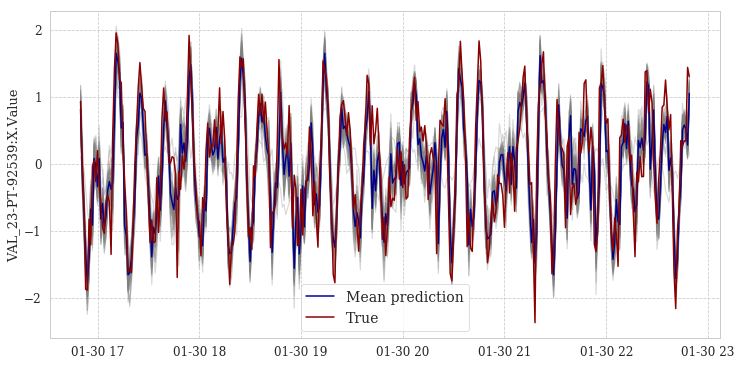


 **** TEST DATA **** 



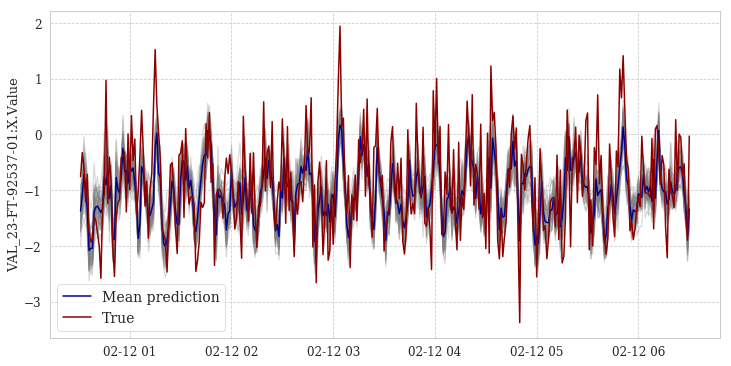

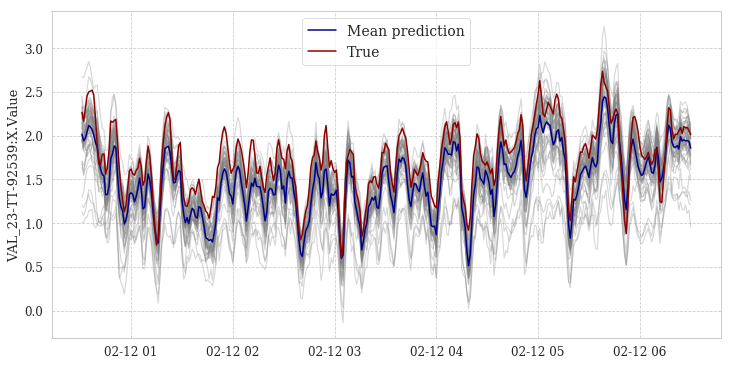

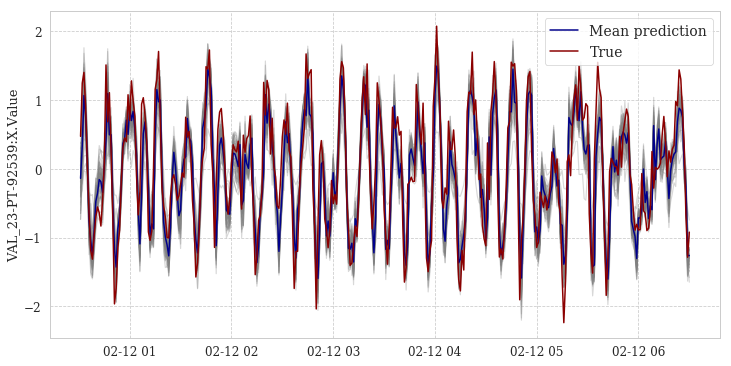


 **** PLOTS /W CI INTERVALS ---
 **** VALIDATION DATA **** 



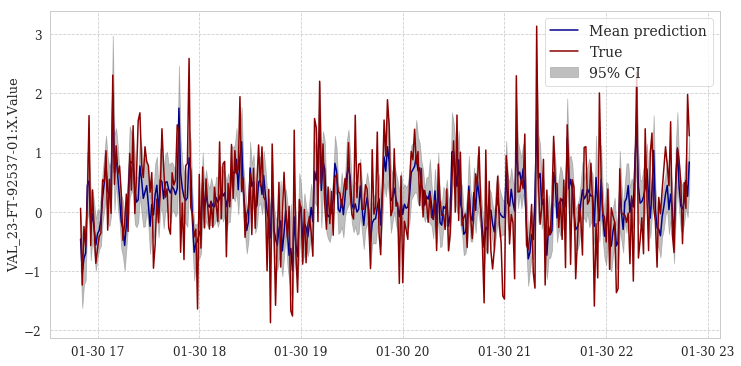

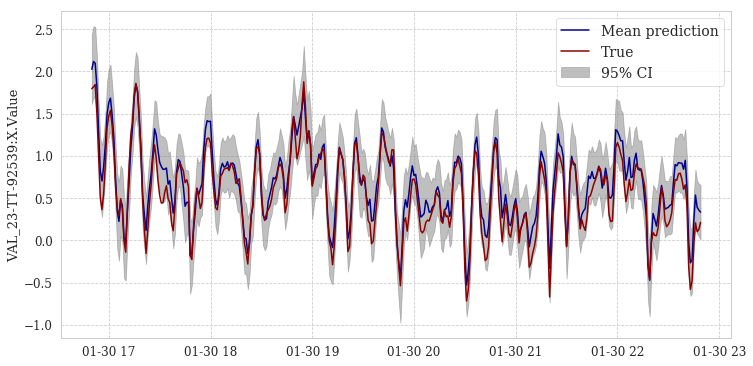

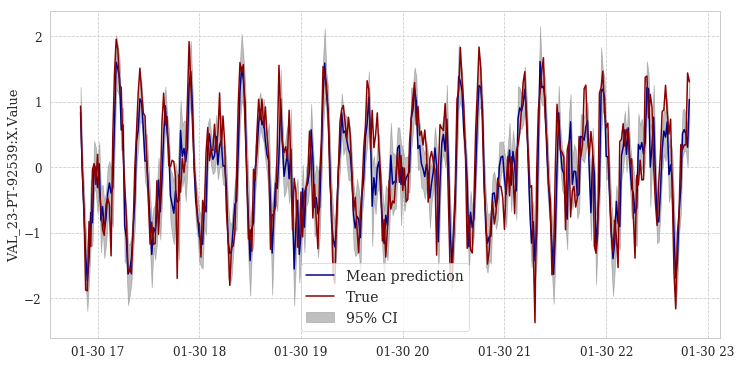


 **** TEST DATA **** 



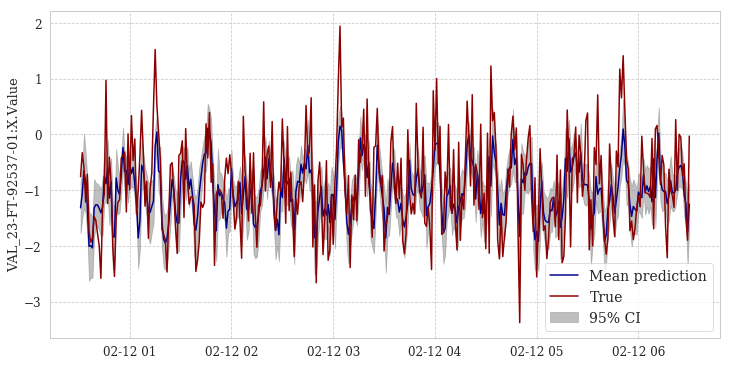

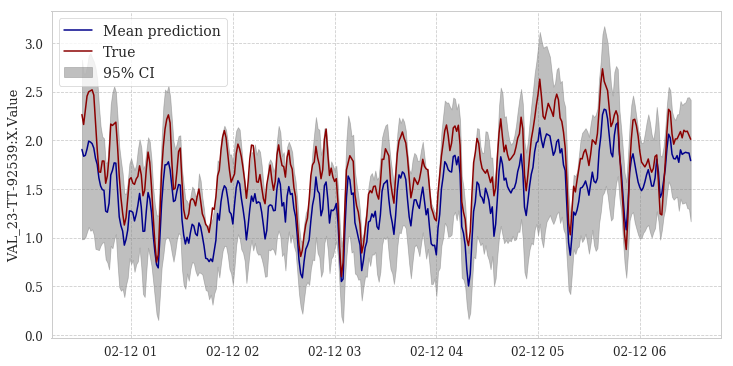

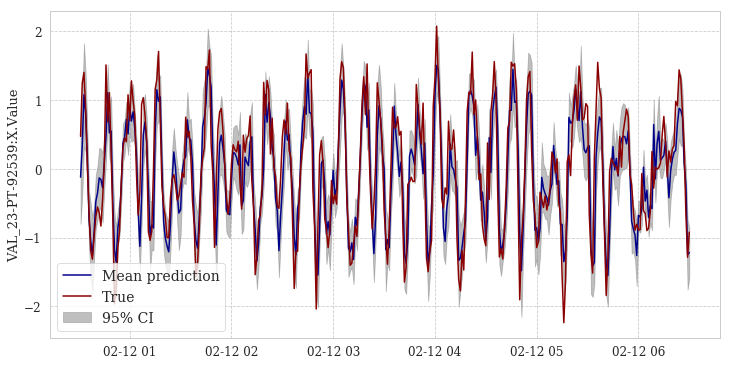

In [28]:
make_summary_for_dict(gru_128_dict)

# Summary of results and exporting

In [29]:
dicts = [lstm_128_dict, gru_128_dict]
columns=["FT", "TT", "PT", "Avg"]
index = ["LSTM", "GRU"]
rnn_summary, tex = get_df_from_dicts(dicts, columns, index)
print(tex)
rnn_summary

\begin{tabular}{lcccccccc}
\toprule
{} & \multicolumn{4}{c}{Validation} & \multicolumn{4}{c}{Test} \\
{} &         FT &      TT &      PT &     Avg &      FT &      TT &      PT &     Avg \\
\midrule
\textbf{LSTM} &     0.6048 &  0.3418 &  0.4296 &  0.4587 &  0.5452 &  0.3161 &  0.4124 &  0.4245 \\
\textbf{GRU } &     0.6181 &  0.3220 &  0.4464 &  0.4622 &  0.5497 &  0.3122 &  0.4242 &  0.4287 \\
\bottomrule
\end{tabular}



Validation                            Test                        
             FT      TT      PT     Avg      FT      TT      PT     Avg
LSTM     0.6048  0.3418  0.4296  0.4587  0.5452  0.3161  0.4124  0.4245
GRU      0.6181  0.3220  0.4464  0.4622  0.5497  0.3122  0.4242  0.4287

In [30]:
dicts = [lstm_128_dict, gru_128_dict]
columns=["MAE", "Exp. Mean", "Exp. Std"]
index = ["LSTM", "GRU"]
levels = ["FT","TT","PT","Avg"]

uncertainty_df, tex = get_uncertainty_df_from_dicts(dicts, columns, index, levels)
print(tex)
uncertainty_df

\begin{tabular}{llcccccc}
\toprule
    &     & \multicolumn{3}{c}{Validation} & \multicolumn{3}{c}{Test} \\
    &     &        MAE & Exp. Mean & Exp. Std &     MAE & Exp. Mean & Exp. Std \\
\midrule
\multirow{4}{*}{\textbf{LSTM}} & \textbf{FT} &     0.6048 &   -0.3117 &   0.1960 &  0.5452 &   -0.4671 &   0.2098 \\
    & \textbf{TT} &     0.3418 &    1.2738 &   0.2485 &  0.3161 &    1.7619 &   0.2104 \\
    & \textbf{PT} &     0.4296 &    0.0083 &   0.1722 &  0.4124 &   -0.0272 &   0.1728 \\
    & \textbf{Avg} &     0.4587 &    0.3234 &   0.2055 &  0.4245 &    0.4225 &   0.1977 \\
\cline{1-8}
\multirow{4}{*}{\textbf{GRU}} & \textbf{FT} &     0.6181 &   -0.2604 &   0.2223 &  0.5497 &   -0.4321 &   0.2205 \\
    & \textbf{TT} &     0.3220 &    1.2370 &   0.2093 &  0.3122 &    1.5945 &   0.2683 \\
    & \textbf{PT} &     0.4464 &   -0.0532 &   0.2076 &  0.4242 &   -0.0807 &   0.1853 \\
    & \textbf{Avg} &     0.4622 &    0.3078 &   0.2131 &  0.4287 &    0.3606 &   0.2247 \\
\bottomrule
\e

Validation                       Test                   
                MAE Exp. Mean Exp. Std     MAE Exp. Mean Exp. Std
LSTM FT      0.6048   -0.3117   0.1960  0.5452   -0.4671   0.2098
     TT      0.3418    1.2738   0.2485  0.3161    1.7619   0.2104
     PT      0.4296    0.0083   0.1722  0.4124   -0.0272   0.1728
     Avg     0.4587    0.3234   0.2055  0.4245    0.4225   0.1977
GRU  FT      0.6181   -0.2604   0.2223  0.5497   -0.4321   0.2205
     TT      0.3220    1.2370   0.2093  0.3122    1.5945   0.2683
     PT      0.4464   -0.0532   0.2076  0.4242   -0.0807   0.1853
     Avg     0.4622    0.3078   0.2131  0.4287    0.3606   0.2247

In [20]:
def get_df_from_dicts(dicts, columns, index, texpath=None, round_digits=4):
    """
    Will make a dataframe with error metrics for each target tag out of a collection of dictionaries 
    as obtained by evaluate_model(). The model names will be collected as indexes in the dataframe, and the 
    target errors in the columns. 
    """
    
    val_maes = []
    test_maes = []
    for d in dicts:
        tmp_mae_val = [round(float(digit),round_digits) for digit in d['validation']['df']['MAE (std)'].tolist()]
        tmp_mae_test = [round(float(digit),round_digits) for digit in d['test']['df']['MAE (std)'].tolist()]

        val_maes.append(tmp_mae_val)
        test_maes.append(tmp_mae_test)

    # make df
    df_val = pd.DataFrame(np.vstack(val_maes), index=index, columns=columns)
    df_test = pd.DataFrame(np.vstack(test_maes), index=index, columns=columns)
    df_summary = pd.concat([df_val, df_test], axis=1, keys=["Validation", "Test"])

    tex = df_summary.to_latex(column_format="l" + "c"*(len(columns)*2),
                              multicolumn=True, 
                              multicolumn_format='c', 
                              bold_rows=True)
    if texpath is not None: 
        with open(texpath) as f:
            f.write(tex)

    return df_summary, tex

In [21]:
def get_uncertainty_df_from_dicts(dicts, columns, index, levels, texpath=None, round_digits=4):
    """
    Will make a dataframe with uncertainty and error metrics for each target tag out of a collection of dictionaries 
    as obtained by evaluate_model().
    """
    
    dataframes = []
    for d in dicts:
        df = d['validation']
        avg_maes = [round(float(digit),round_digits) for digit in df['df']['MAE (std)'].tolist()]
        exp_means = [round(float(digit),round_digits) for digit in df['df']['Expect. Mean'].tolist()]
        exp_stds = [round(float(digit),round_digits) for digit in df['df']['Expect. Stdev'].tolist()]
        df_1 = pd.DataFrame(np.column_stack([avg_maes, exp_means, exp_stds]), index = levels, columns = columns)

        df = d['test']
        avg_maes = [round(float(digit),round_digits) for digit in df['df']['MAE (std)'].tolist()]
        exp_means = [round(float(digit),round_digits) for digit in df['df']['Expect. Mean'].tolist()]
        exp_stds = [round(float(digit),round_digits) for digit in df['df']['Expect. Stdev'].tolist()]
        df_2 = pd.DataFrame(np.column_stack([avg_maes, exp_means, exp_stds]), index = levels, columns = columns)
        df_concat = pd.concat([df_1, df_2], axis=1, keys=["Validation", "Test"])
        dataframes.append(df_concat)
    
    summary_df = pd.concat(dataframes, axis=0, keys=index)
    
    tex = summary_df.to_latex(column_format="ll" + "c"*(len(columns)*2),
                              multicolumn=True, 
                              multicolumn_format='c',
                              multirow=True,
                              bold_rows=True)

    if texpath is not None: # save the file
        with open(texpath, 'w+') as f:
            f.write(tex)
    
    return summary_df, tex

In [32]:
path = ROOT_PATH + "models/dataframes/"

rnn_summary.to_pickle(path + "rnn_summary_df.pkl")
uncertainty_df.to_pickle(path + "rnn_uncertainty_df.pkl")